# Project 2: Text Mining on COVID-19 Research Paper Dataset
### Author: Weiqi Wang, Shaoliang Ni

# 1 Project Objectives 

This project aims at perform text mining and exploratory data analysis on COVID-19 Research Paper Dataset. The contents includes load and manipulate json data, data transformation, text staticstics, text summarisation, text transformation, word frequency visualization, related paper recommendation (measure similarity), document clustering, topic modeling, exploratory data analysis and visualization on metadata, and so on.

# 2 Data Description

In response to the COVID-19 pandemic, the White House and a coalition of leading research groups have prepared the COVID-19 Open Research Dataset (CORD-19). CORD-19 is a resource of over 57,000 scholarly articles, including over 45,000 with full text, about COVID-19, SARS-CoV-2, and related coronaviruses. The paper and the metadata are store in the json files.

There are 4 types of papers in this dataset, biorxiv_medrxiv, commercial use, non-commercial use, and custom use papers. We mainly use the first three subset. There are 2278 json files in biorxiv_medrxiv (466MB), 9769 json files in commercial use (3.2GB), 2518 json files in non-commercial use (689MB). We mainly utilize the biorxiv_medrxiv subset and the metadata csv file (88MB) to test on the text mining functions.

Data source: https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge

# 3 Load Data and Data Preprocessing

## 3.1 Load packages

In [79]:
library(jsonlite)
library(plyr)
library(tidyr)
library(dplyr)
library(ggplot2)
library(ggpubr)
library(igraph)
library(ggraph)
library(stringi)
library(lexRankr)
library(SnowballC)
library(wordcloud)
library(RColorBrewer)
library(wordcloud2)
library(tm)
library(ddpcr)
library(cluster)
library(fpc)
library(stringi)
library(stringr)
library(reshape2)
library(widyr)
library(topicmodels)
library(tidytext)

Warning message:
“package ‘tidytext’ was built under R version 3.6.2”

Attaching package: ‘tidytext’


The following object is masked from ‘package:lexRankr’:

    unnest_sentences




## 3.2 Load data

### create a raw json list for 3 types of papers

In [2]:
# create path for 3 json files dir
path.bm <- "/Users/weiqiwang/UMN/Course/IE 5561/Project2/Data/CORD-19-research-challenge/biorxiv_medrxiv/biorxiv_medrxiv/pdf_json"
path.comm <- "/Users/weiqiwang/UMN/Course/IE 5561/Project2/Data/CORD-19-research-challenge/comm_use_subset/comm_use_subset/pdf_json"
path.noncomm <- "/Users/weiqiwang/UMN/Course/IE 5561/Project2/Data/CORD-19-research-challenge/noncomm_use_subset/noncomm_use_subset/pdf_json"

# create a raw json list for biorxiv_medrxiv articles
files.bm <- list.files(path.bm)
raw.list.bm <- list()
for (i in 1:length(files.bm)){
  raw.list.bm[[i]] <- fromJSON(file.path(path.bm, files.bm[i]))
}

# create a raw json list for commercial use articles
files.comm <- list.files(path.comm)
raw.list.comm <- list()
for (i in 1:length(files.comm)){
  raw.list.comm[[i]] <- fromJSON(file.path(path.comm, files.comm[i]))
}

# create a raw json list for non-commercial use articles
files.noncomm <- list.files(path.noncomm)
raw.list.noncomm <- list()
for (i in 1:length(files.noncomm)){
  raw.list.noncomm[[i]] <- fromJSON(file.path(path.noncomm, files.noncomm[i]))
}

## 3.3 Data preprocessing

### Parse list to data frame (structured data)

In [3]:
# function that help create a string
paste_noNA <- function(x,sep=", ") {
  gsub(", " ,sep, toString(x[!is.na(x) & x!="" & x!="NA"] ) ) 
}

# create a function to regularize author format
format.author <- function(list, i){
  if (typeof(list[[i]]$metadata$authors$middle[[1]])=="character"){
    middle <- unlist(lapply(list[[i]]$metadata$authors$middle, 
                            function(x) if(identical(x, character(0))) NA_character_ else x)) # preprocess
    middle <- gsub("[[:punct:]]", replacement = NA_character_, middle)
    df.authors <- data.frame(first = list[[i]]$metadata$authors$first, 
                             middle, 
                             last = list[[i]]$metadata$authors$last)
  } else {
    df.authors <- data.frame(first = list[[i]]$metadata$authors$first, 
                             last = list[[i]]$metadata$authors$last)
  }
  sep=" "
  df.authors <- apply(df.authors, 1 , paste_noNA , sep=sep)
  df.authors <- gsub("[[:punct:]]", replacement="", df.authors)
  return(df.authors)
}

# create a function to regularize affiliation format
format.affiliation <- function(list, i, list.authors){
  df.affiliation <- list[[i]]$metadata$authors$affiliation
  location <- as.vector(apply(df.affiliation$location, 1, paste_noNA, sep=", "))
  df.affiliation <- data.frame(laboratory = df.affiliation$laboratory, 
                               institution = df.affiliation$institution, 
                               location)
  df.affiliation <- apply(df.affiliation, 1, paste_noNA, sep=", ")
  affiliation <- rep(NA, length(df.affiliation))
  for (j in 1:length(df.affiliation)) {
    affiliation[j] <- paste0(list.authors[j], " (", df.affiliation[j],")")
  }
return(affiliation)
}

# create a function to convert list to dataframe
list.to.df <- function(list){
  paper_id <- rep(NA, length(list))
  title <- rep(NA, length(list))
  authors <- rep(NA, length(list))
  list.authors <- list()
  list.affiliations <- list()
  affiliations <- rep(NA, length(list))
  abstract <- rep(NA, length(list))
  text <- rep(NA, length(list))
  for (i in 1:length(list)) {
    paper_id[i] <- list[[i]]$paper_id
    title[i] <- list[[i]]$metadata$title
    # create a col for authors
    list.authors[[i]] <- format.author(list, i)
    authors[i] <- paste(list.authors[[i]], collapse = ', ')
    # create a col for authors' affiliations
    if (length(list[[i]]$metadata$authors$affiliation)!=0){
      list.affiliations[[i]] <- format.affiliation(list, i, list.authors[[i]])
      affiliations[i] <- paste(list.affiliations[[i]], collapse = ', ')
    }
    abstract[i] <- paste(list[[i]]$abstract$text, collapse = '')
    text[i] <- paste(list[[i]]$body_text$text, collapse = '')
  }
  df <- data.frame(paper_id, title, authors, affiliations, abstract, text)
  return(df)
}

# create data frames
df.bm <- list.to.df(raw.list.bm)
df.noncomm <- list.to.df(raw.list.noncomm)
df.comm <- list.to.df(raw.list.comm)

### View data frame

In [6]:
# View data frame
df.bm[1:2,]

paper_id                                
1 0015023cc06b5362d332b3baf348d11567ca2fbb
2 00340eea543336d54adda18236424de6a5e91c9d
  title                                                                                                                                               
1 The RNA pseudoknots in foot-and-mouth disease virus are dispensable for genome replication but essential for the production of infectious virus. 2 3
2 Analysis Title: Regaining perspective on SARS-CoV-2 molecular tracing and its implications                                                          
  authors                                                                                                                                                                                                                             
1 Joseph C Ward, Lidia LaseckaDykes, Chris Neil, Oluwapelumi Adeyemi, Sarah, Gold, Niall Mclean, Caroline Wright, Morgan R Herod, David Kealy, Emma, Warner, Donald P King, Tobias J Tuthill, David J Rowlands, Nicola J, Stonehouse A
2 Carla Mavian, Simone Marini, Costanza Manes, Ilaria Capua, Mattia Prosperi, Marco Salemi                                                                                                                                            
  affiliations                                                                                                                                                                                                                                                                                                                                                                
1 NA                                                                                                                                                                                                                                                                                                                                                                          
2 Carla Mavian (University of Florida, Gainesville, FL, USA), Simone Marini (University of Florida, Gainesville, FL, USA), Costanza Manes (University of Florida, Gainesville, FL, USA), Ilaria Capua (University of Florida, Gainesville, FL, USA), Mattia Prosperi (University of Florida, Gainesville, FL, USA), Marco Salemi (University of Florida, Gainesville, FL, USA)
  abstract                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

### Create a table that includes paper id, title, abstract, main text and word statistics

In [7]:
output = matrix(ncol=7, nrow=length(raw.list.bm))

for (i in 1:length(raw.list.bm)){
    
  output[i,1] <- raw.list.bm[[i]]$paper_id
  output[i,2] <- raw.list.bm[[i]]$metadata$title
  output[i,3] <- toString(raw.list.bm[[i]]$abstract$text)
  output[i,4] <- toString(raw.list.bm[[i]]$body_text$text)
  output[i,5] <- stri_stats_latex(toString(raw.list.bm[[i]]$body_text$text))[1]
  output[i,6] <- stri_stats_latex(toString(raw.list.bm[[i]]$body_text$text))[3]
  output[i,7] <- stri_stats_latex(toString(raw.list.bm[[i]]$body_text$text))[4]  
}

colnames(output) <- c("paperid", "title", "abstract", "bodyText", "CharsWord", "CharsWhite", "Words")

In [22]:
# View output table
head(output, 3)

paperid                                 
[1,] 0015023cc06b5362d332b3baf348d11567ca2fbb
[2,] 00340eea543336d54adda18236424de6a5e91c9d
[3,] 004f0f8bb66cf446678dc13cf2701feec4f36d76
     title                                                                                                                                               
[1,] The RNA pseudoknots in foot-and-mouth disease virus are dispensable for genome replication but essential for the production of infectious virus. 2 3
[2,] Analysis Title: Regaining perspective on SARS-CoV-2 molecular tracing and its implications                                                          
[3,] Healthcare-resource-adjusted vulnerabilities towards the 2019-nCoV epidemic across China                                                            
     abstract                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
[1,] word count: 194 22 Text word count: 5168 23 24 25 author/funder. All rights reserved. No reuse allowed without permission. Abstract 27 The positive stranded RNA genomes of picornaviruses comprise a single large open reading 28 frame flanked by 5′ and 3′ untranslated regions (UTRs). Foot-and-mouth disease virus (FMDV) 29 has an unusually large 5′ UTR (1.3 kb) containing five structural domains. These include the 30 internal ribosome entry site (IRES), which facilitates initiation of translation, and the cis-acting 31 replication element (cre). Less well characterised structures are a 5′ terminal 360 nucleotide 32 stem-loop, a variable length poly-C-tract of approximately 100-200 nucleotides and a series of 33 two to four tandemly repeated pseudoknots (PKs). We investigated the structures of the PKs 34 by selective 2′ hydroxyl acetylation analysed by primer extension (SHAPE) analysis and 35 determined their contribution to genome replication by mutation and deletion experiments. 36 SHAPE and mutation experiments confirmed the importance of the previously predicted PK 37 structures for their function. Deletion experiments showed that although PKs are not essential 38, for replication, they provide genomes with a competitive advantage. However, although 39 replicons and full-length genomes lacking all PKs were replication competent, no infectious 40 virus was rescued from genomes containing less than one PK copy. This is consistent with our 41 earlier report describing the presence of putative packaging signals in the PK region. 42 43 author/f

### Character counts, white space counts and word counts histogram

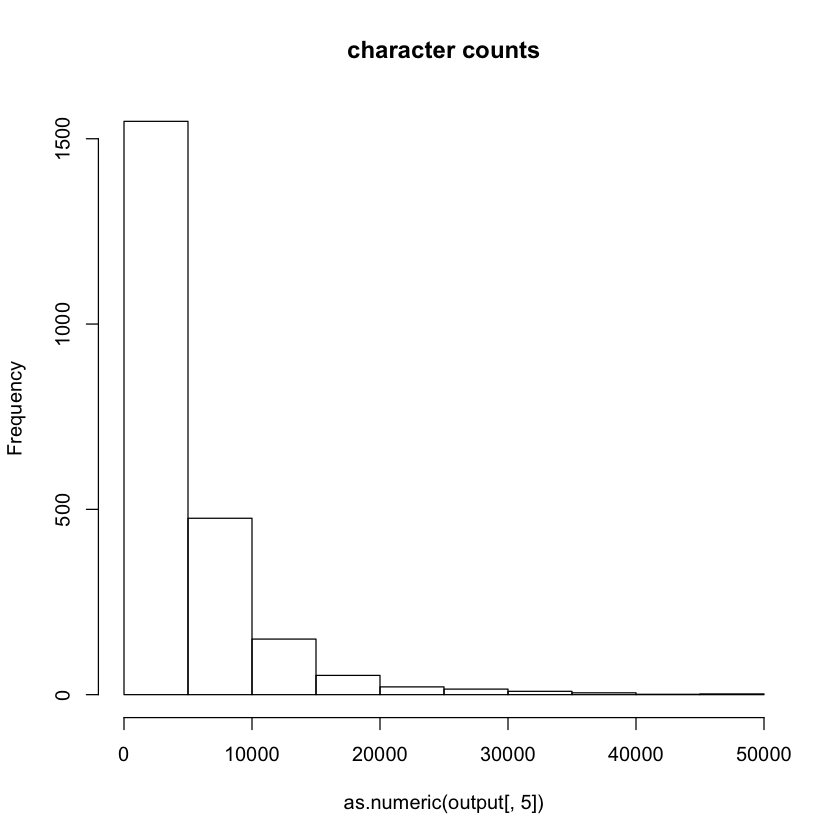

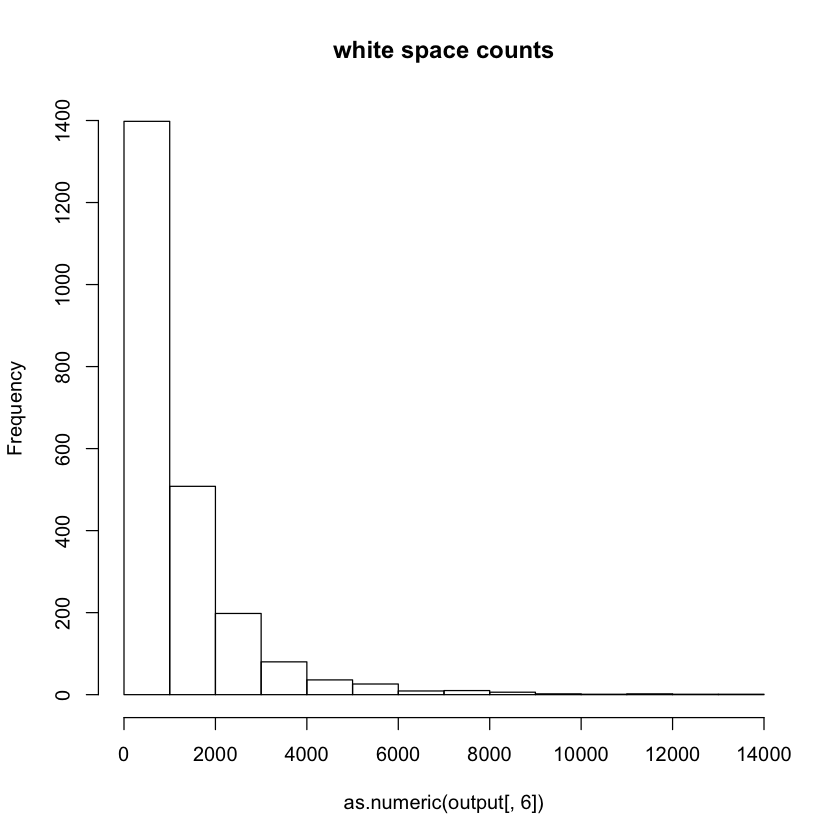

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      2    1062    2979    4613    6028   48406 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0   253.2   713.0  1133.5  1461.0 13227.0 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0   192.2   549.5   869.7  1124.8  9877.0 

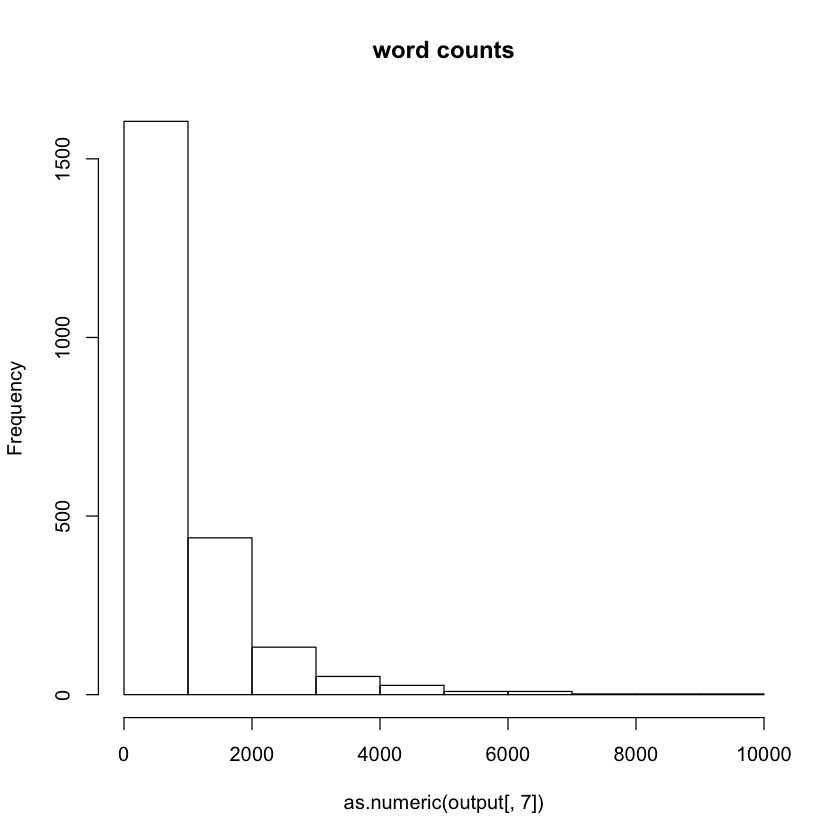

In [8]:
hist(as.numeric(output[,5]),main="character counts")
hist(as.numeric(output[,6]),main="white space counts")
hist(as.numeric(output[,7]),main="word counts")

summary(as.numeric(output[,5])) #charcters
summary(as.numeric(output[,6])) # white space
summary(as.numeric(output[,7])) # words

# 4 Text Mining

## 4.1 Text summarization

Now we introduce the lexRank algorithm. It summarize the text based on the similarities of sentences in the text. The edges between sentences are based on some form of semantic similarity or content overlap. The sentences are ranked by applying PageRank. A summary is formed by combining the top ranking sentences, using a threshold to limit the size of the summary.

Here is a demo of lexRank function to summarize the one abstract text.

### A sample text summarization on an abstract

In [16]:
abs_x <- as.character(df.bm$abstract[1])

top_5 <- lexRank(abs_x,
                 #only 1 article; repeat same docid for all of input vector
                 docId = rep(1, length(abs_x)),
                 #return 5 sentences to mimick /u/autotldr's output
                 n = 5,
                 continuous = TRUE)

#reorder the top 5 sentences to be in order of appearance in article
order_of_appearance = order(as.integer(gsub("_","",top_5$sentenceId)))
#extract sentences in order of appearance
ordered_top_5 = top_5[order_of_appearance, "sentence"]

Parsing text into sentences and tokens...DONE
Calculating pairwise sentence similarities...DONE
Applying LexRank...DONE
Formatting Output...DONE


### View the abstract summarisation

Here are top 5 important sentences in the text:

In [17]:
top_5
ordered_top_5

docId sentenceId
1 1     1_8       
2 1     1_10      
3 1     1_11      
4 1     1_9       
5 1     1_7       
  sentence                                                                                                                                                                                                                        
1 We investigated the structures of the PKs 34 by selective 2′ hydroxyl acetylation analysed by primer extension (SHAPE) analysis and 35 determined their contribution to genome replication by mutation and deletion experiments.
2 Deletion experiments showed that although PKs are not essential 38for replication, they provide genomes with a competitive advantage.                                                                                           
3 However, although 39 replicons and full-length genomes lacking all PKs were replication competent, no infectious 40 virus was rescued from genomes containing less than one PK copy.                                            
4 36 SHAPE and mutation experiments confirmed the importance of the previously predicted PK 37 structures for their function.                                                                                                     
5 Less well characterised structures are a 5′ terminal 360 nucleotide 32 stem-loop, a variable length poly-C-tract of approximately 100-200 nucleotides and a series of 33 two to four tandemly repeated pseudoknots (PKs).       
  value     
1 0.09634529
2 0.09082879
3 0.09069826
4 0.08020814
5 0.07758597

[1] "Less well characterised structures are a 5′ terminal 360 nucleotide 32 stem-loop, a variable length poly-C-tract of approximately 100-200 nucleotides and a series of 33 two to four tandemly repeated pseudoknots (PKs)."       
[2] "We investigated the structures of the PKs 34 by selective 2′ hydroxyl acetylation analysed by primer extension (SHAPE) analysis and 35 determined their contribution to genome replication by mutation and deletion experiments."
[3] "36 SHAPE and mutation experiments confirmed the importance of the previously predicted PK 37 structures for their function."                                                                                                     
[4] "Deletion experiments showed that although PKs are not essential 38for replication, they provide genomes with a competitive advantage."                                                                                           
[5] "However, although 39 replicons and full-length genomes lacking all PKs were replication competent, no infectious 40 virus was rescued from genomes containing less than one PK copy."

### Text summarisation on main text

In [18]:
t <- output[,c(1,4)]
t <- as.data.frame(t, stringsAsFactors = F)
t$textsum <- NA
dim(t)

[1] 2278    3

In [ ]:
for(i in 1:nrow(t)){
top_5 = lexRankr::lexRank(t[i,2],
                      #only 1 article; repeat same docid for all of input vector
                      docId = rep(1, length(t[i,2])),
                      #return 5 sentences to mimick /u/autotldr's output
                      n = 5,
                      continuous = TRUE)

#reorder the top 5 sentences to be in order of appearance in article
order_of_appearance = order(as.integer(gsub("_","",top_5$sentenceId)))
#extract sentences in order of appearance
ordered_top_5 = top_5[order_of_appearance, "sentence"]
t[i,3] <- toString(ordered_top_5)
}

# clean the text summarization
t$textsum <- gsub('http\\S* ', "", t$textsum)
t$textsum <- gsub('doi: medRxiv preprint ', "", t$textsum)

### View the text summarisation table

In [21]:
# View text summarisation table
head(t, 3)

paperid                                 
1 0015023cc06b5362d332b3baf348d11567ca2fbb
2 00340eea543336d54adda18236424de6a5e91c9d
3 004f0f8bb66cf446678dc13cf2701feec4f36d76
  bodyText                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

## 4.2 Text transformation (cleaning text)

In [23]:
# function that help clean text (Num transform)
remove_alone_nbr <- function (x){
  gsub('\\s*(?<!\\B|-)\\d+(?!\\B|-)\\s*', "", x, perl=TRUE)
}

# function that help clean text (Punctuation transform)
removeMostPunctuation<-
function (x, preserve_intra_word_dashes = FALSE) {
    rmpunct <- function(x) {
        x <- gsub("#", "\002", x)
        x <- gsub("[[:punct:]]+", "", x)
        gsub("\002", "#", x, fixed = TRUE)
    }
    if (preserve_intra_word_dashes) { 
        x <- gsub("(\\w)-(\\w)", "\\1\001\\2", x)
        x <- rmpunct(x)
        gsub("\001", "-", x, fixed = TRUE)
    } else {rmpunct(x)}
}

## generate a function to transform text data to clean text
cleanText <- function(docs){
  # remove numbers
  docs <- tm_map(docs, remove_alone_nbr)

  # remove punctuation except for dash
  docs <- tm_map(docs, content_transformer(removeMostPunctuation),
                 preserve_intra_word_dashes = TRUE)

  docs <- tm_map(docs, stripWhitespace)
  docs <- tm_map(docs, content_transformer(tolower))
  docs <- tm_map(docs, removeWords, c(stopwords("english"), 'doi', 'preprint', 'copyright', 'org', 'https', 'et', 'al', 'author', 'figure', 'table', 'rights', 'reserved', 'permission', 'use', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 'al.', 'Elsevier', 'PMC', 'CZI', '-PRON-', 'usually', 'can', 'may', 'one', 'two', 'three', 'four', 'also', 'will', 'with', 'without', 'however', 'but', 'per', 'thus', 'since', 'even', 'httpsdoiorgdoi'))
  # docs <- tm_map(docs, stemDocument, language = "english")
  return(docs)
}

## 4.3 Vectorization (tf-idf) and Word Frequency (word cloud)

### Generate term-doc matrix and word cloud on main text

Warning message in tm_map.SimpleCorpus(docs, remove_alone_nbr):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(docs, content_transformer(removeMostPunctuation), :
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(docs, stripWhitespace):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(docs, content_transformer(tolower)):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(docs, removeWords, c(stopwords("english"), :
“transformation drops documents”


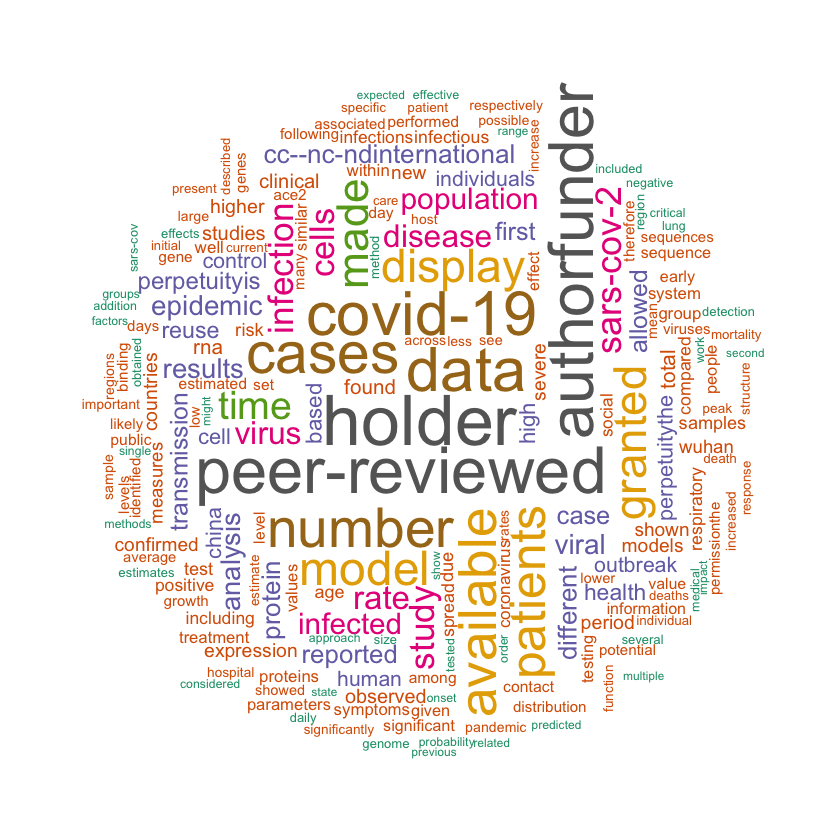

In [24]:
#Create a vector containing only the text
text <- df.bm$text

# Create a corpus  
docs <- Corpus(VectorSource(text))

## clean the text data
docs <- cleanText(docs)

## generate the term-doc matrix with term frequencies
tdm.text <- as.matrix(TermDocumentMatrix(docs))

words <- sort(rowSums(tdm.text), decreasing=TRUE) 
word.freq <- data.frame(word = names(words), freq=words)

## generate the word cloud
set.seed(1234) # for reproducibility 
wordcloud(words = word.freq$word, freq = word.freq$freq, min.freq = 1, max.words=200, random.order=FALSE, rot.per=0.35, colors=brewer.pal(8, "Dark2"), scale=c(3.5,0.25))
# wordcloud2(data=word.freq, size=1.6, color='random-dark')

### Generate term-doc matrix and word cloud on abstract

Warning message in tm_map.SimpleCorpus(docs, remove_alone_nbr):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(docs, content_transformer(removeMostPunctuation), :
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(docs, stripWhitespace):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(docs, content_transformer(tolower)):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(docs, removeWords, c(stopwords("english"), :
“transformation drops documents”


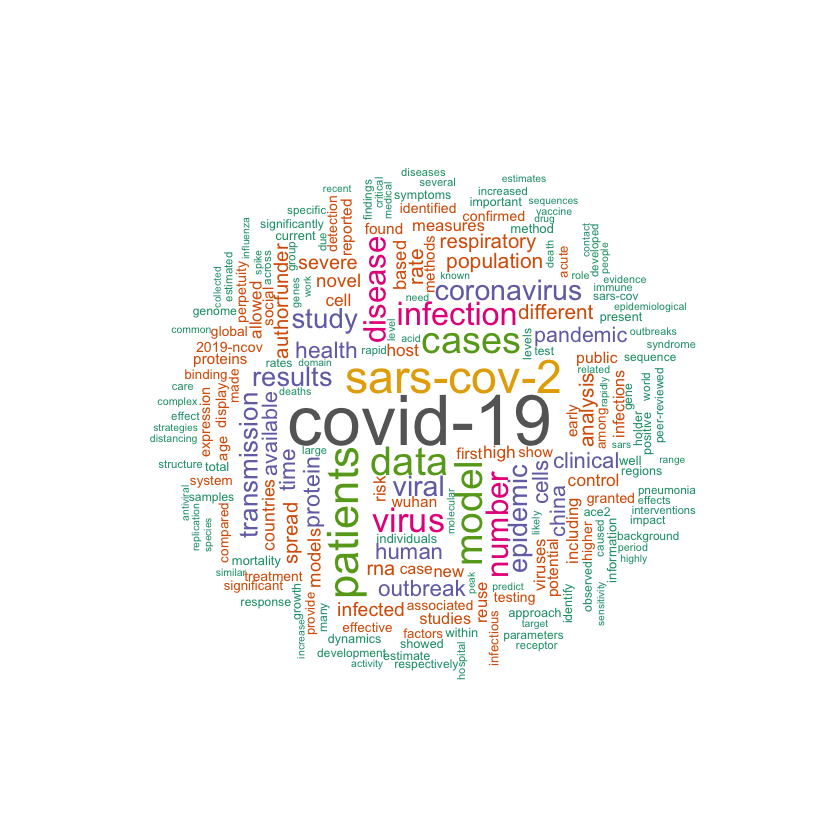

In [25]:
#Create a vector containing only the abstract
abs <- data.frame(output)$abstract

# Create a corpus  
docs <- Corpus(VectorSource(abs))

## clean the text data
docs <- cleanText(docs)

## generate the term-doc matrix with term frequencies
tdm.abs <- as.matrix(TermDocumentMatrix(docs))

words <- sort(rowSums(tdm.abs), decreasing=TRUE) 
word.freq <- data.frame(word = names(words), freq=words)

## generate the word cloud
set.seed(1234) # for reproducibility 
wordcloud(words = word.freq$word, freq = word.freq$freq, min.freq = 1, max.words=200, random.order=FALSE, rot.per=0.35, colors=brewer.pal(8, "Dark2"), scale=c(3.5,0.25))
# wordcloud2(data=word.freq, size=1.6, color='random-dark')

### Generate term-doc matrix and word cloud on title

Warning message in tm_map.SimpleCorpus(docs, remove_alone_nbr):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(docs, content_transformer(removeMostPunctuation), :
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(docs, stripWhitespace):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(docs, content_transformer(tolower)):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(docs, removeWords, c(stopwords("english"), :
“transformation drops documents”


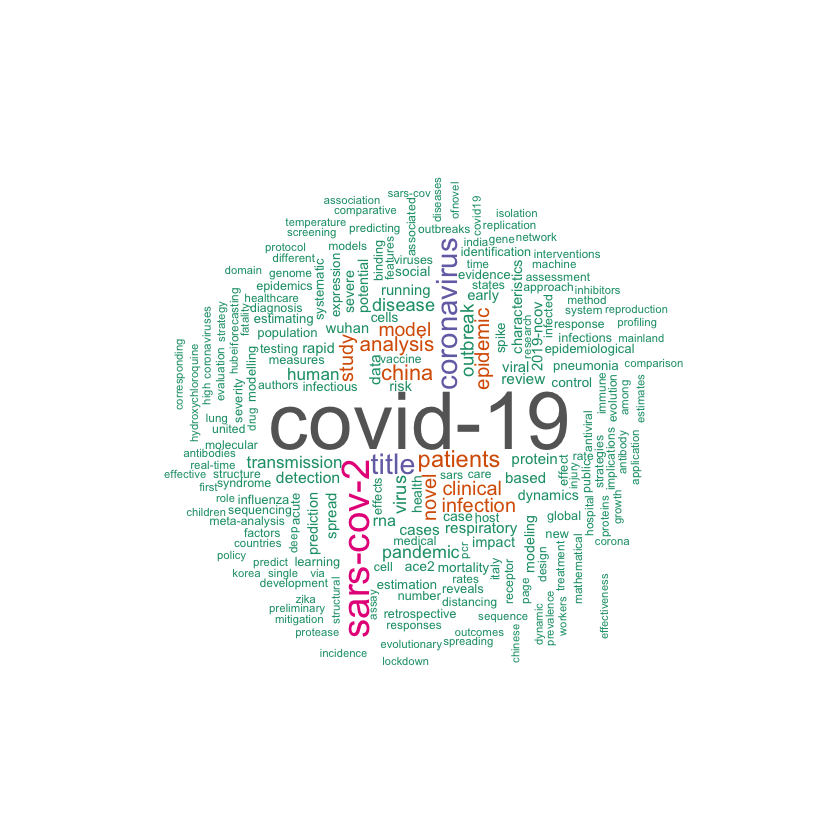

In [27]:
#Create a vector containing only the abstract
title <- data.frame(output)$title

# Create a corpus  
docs <- Corpus(VectorSource(title))

## clean the text data
docs <- cleanText(docs)

## generate the term-doc matrix with term frequencies
tdm.title <- as.matrix(TermDocumentMatrix(docs))

words <- sort(rowSums(tdm.title), decreasing=TRUE) 
word.freq <- data.frame(word = names(words), freq=words)

## generate the word cloud
set.seed(1234) # for reproducibility 
wordcloud(words = word.freq$word, freq = word.freq$freq, min.freq = 1, max.words=200, random.order=FALSE, rot.per=0.35, colors=brewer.pal(8, "Dark2"))
# wordcloud2(data=word.freq, size=1.6, color='random-dark')

## 4.4 Measure Similarity (find the most related paper)

In [28]:
## functions that helps
norm2 <- function(v) sqrt(sum(v^2))
cosine.sim <- function(v1, v2) {
  (v1 %*% v2) / (norm2(v1) * norm2(v2))
}

## compute the cosine simularity matrix
cos.sim <- matrix(data = NA, nrow = ncol(tdm.text), ncol = ncol(tdm.text))
for (d1 in 1:ncol(tdm.text)) {
  for (d2 in (c(1:ncol(tdm.text))[-d1])){
    cos.sim[d1, d2] <- cosine.sim(tdm.text[d1,], tdm.text[d2,]) 
  } 
}

## query the top 5 related papers of the first paper
topSimilarity <- function(doc, df, cos.sim){
  i <- match(doc, df$paper_id)
  score <- sort(cos.sim[,i], index.return=TRUE, decreasing=TRUE)
  df.sim <- data.frame(lapply(score, `[`, score$x %in% head(unique(score$x),5)))
  df.sim$paper_id <- df.bm$paper_id[df.sim$ix]
  df.sim <- data.frame(paper_id = df.sim$paper_id, similarity = df.sim$x)
  return(df.sim)
}
topSimilarity("0015023cc06b5362d332b3baf348d11567ca2fbb", df.bm, cos.sim)

paper_id                                 similarity
1 9278653610050118f2a986352b1c1ce36533639c 0.1907679 
2 12c27668d532b86334400132f83b995a7df41b2d 0.1668011 
3 1cd111d93cd8e829e5ebadc92c9cb04f69b0948b 0.1624941 
4 05d99c07db59b6948e39bfa62c2cbbf62944059a 0.1564627 
5 35d36c0a736ae7ca642a8badd24bf4d9be3ca613 0.1560970

## 4.5 Low rank approximation of the term-doc matrix

In [ ]:
## svd of tdm
tdm.text.svd <- svd(tdm.text)
U <- tdm.text.svd$u       # the term matrix
V <- tdm.text.svd$v       # the doc matrix
S <- diag(tdm.text.svd$d) # singular values

## zero out all but the 700 largest singular values
diag(S) <- c(tdm.text.svd$d[1:700],rep(0, (nrow(df.bm)-700)))

tdm.text.low.rank <- (U %*% S) %*% t(V)  # the rank-700 approx to tdm.text

## compute the cosine simularity matrix
cos.sim.low.rank <- matrix(data = NA, nrow = ncol(tdm.text.low.rank), ncol = ncol(tdm.text.low.rank))
for (d1 in 1:ncol(tdm.text.low.rank)) {
  for (d2 in (c(1:ncol(tdm.text.low.rank))[-d1])){
    cos.sim.low.rank[d1, d2] <- cosine.sim(tdm.text.low.rank[d1,], tdm.text.low.rank[d2,]) 
  } 
}

## the most related paper of the first paper
topSimilarity("0015023cc06b5362d332b3baf348d11567ca2fbb", df.bm, cos.sim.low.rank)

## 4.6 Clustering

### Clustering (hierarchical)

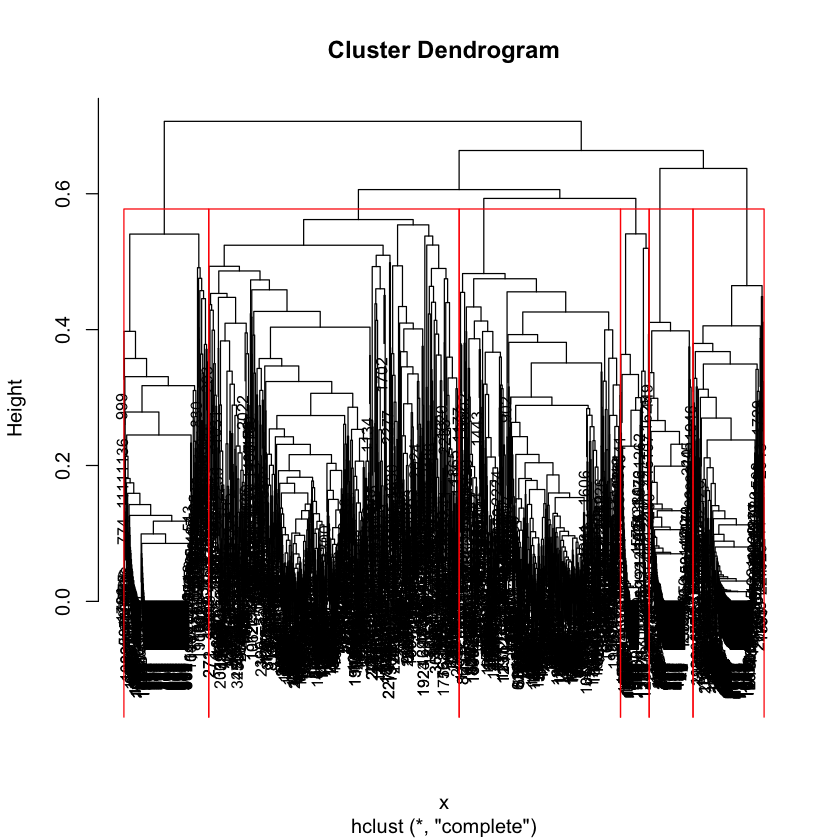

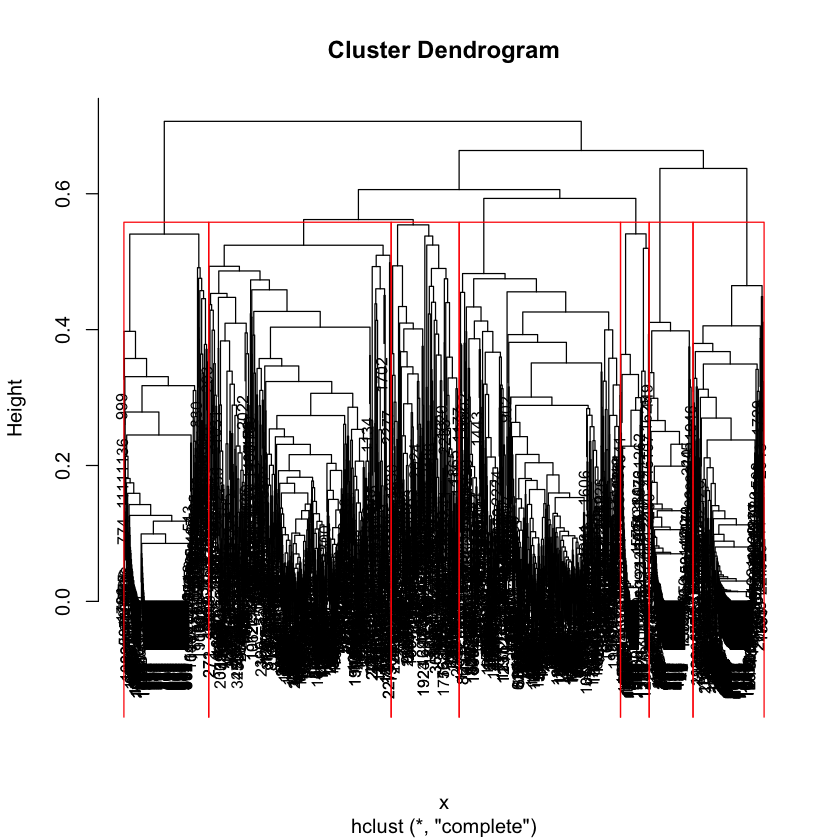

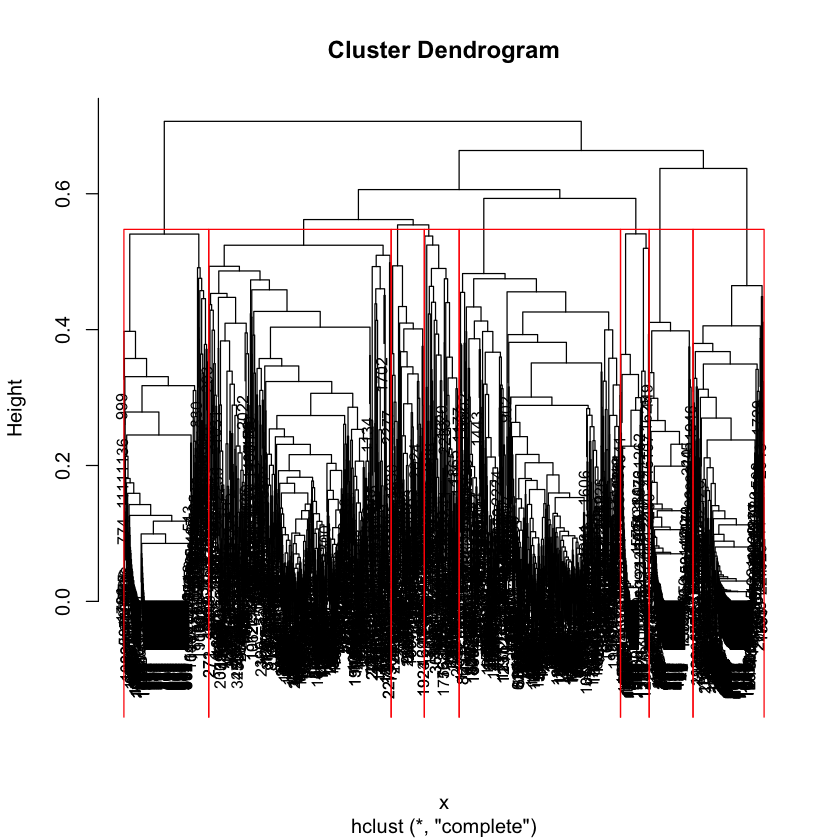

In [29]:
cos.dist <- 1 - cos.sim # compute cosine distance
diag(cos.dist) <- rep(0, nrow(cos.dist))
# agglomerative hierarchical clustering
hclustfunc <- function(x) hclust(x, method="complete")
distfunc <- function(x) as.dist((1-cor(t(x)))/2)
d <- distfunc(cos.dist)
fit <- hclustfunc(d)
# cut the tree at 6 clusters
plot(fit, cex=.8)
rect.hclust(fit, 6, border = "red")
# cut the tree at 7 clusters
plot(fit, cex=.8)
rect.hclust(fit, 7, border = "red")
# cut the tree at 8 clusters
plot(fit, cex=.8)
rect.hclust(fit, 8, border = "red")
# create 8 clusters
clustering <- cutree(fit, 8)

### Topic modeling (extract keywords) of each clusters

In [30]:
p_words <- rowSums(tdm.text) / sum(tdm.text)
cluster_words <- lapply(unique(clustering), function(x){
  cols <- tdm.text[,clustering == x]
  cols <- cols[rowSums(cols)>0,]
  rowSums(cols) / sum(cols) - p_words[rownames(cols)]
})
# create a summary table of clusters
cluster.summary <- data.frame(cluster = unique(clustering),
                              size = as.numeric(table(clustering)),
                              top_words = sapply(cluster_words, function(d){
                                paste(names(d)[order(d, decreasing = T)][1:5], collapse = ", ")
                              }), stringsAsFactors = F)
cluster.summary

cluster size top_words                                      
1 1       574  cells, information, data, parkin, disease      
2 2       156  incidence, wuhan, period, travel, infectious   
3 3       649  cells, cell, covid-19, ace2, testing           
4 4       118  social, distancing, time, cases, lockdown      
5 5       124  sequences, assays, infected, set, assay        
6 6       302  patients, viruses, species, sars, care         
7 7       102  number, gene, infection, influenza, cases      
8 8       253  population, epidemic, strains, travel, measures

### Generate word cloud on each clusters

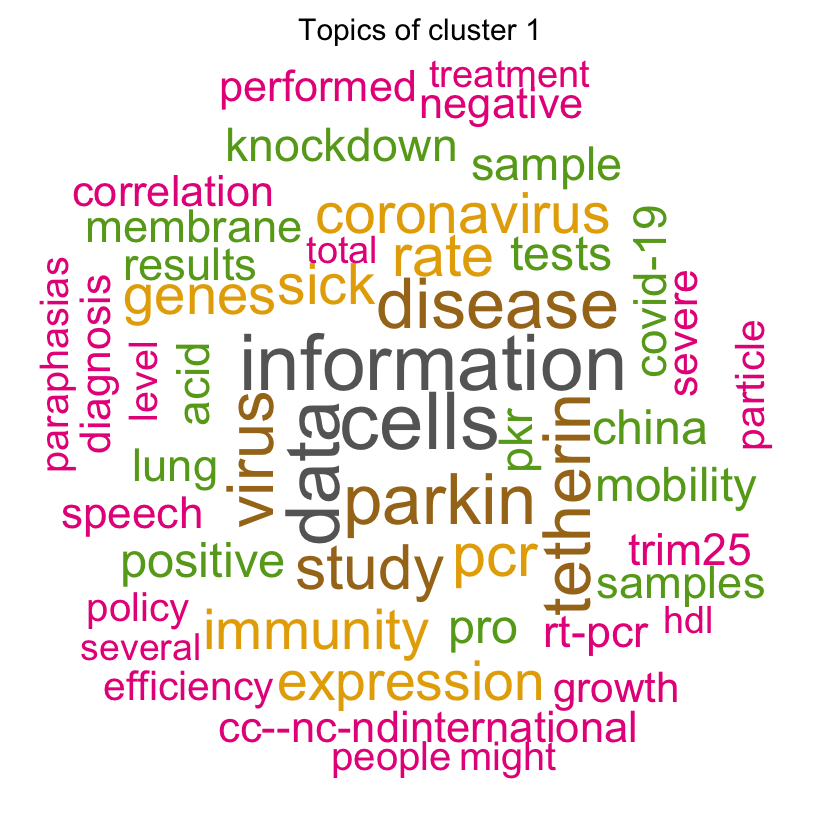

In [39]:
# par(mfrow=c(2,4))
wordcloud(words = names(cluster_words[[1]]), freq = cluster_words[[1]], main = text(x=0.5, y=1, cex = 1.5, "Topics of cluster 1"), max.words = 50, random.order = F, rot.per=0.35, colors=brewer.pal(8, "Dark2"))

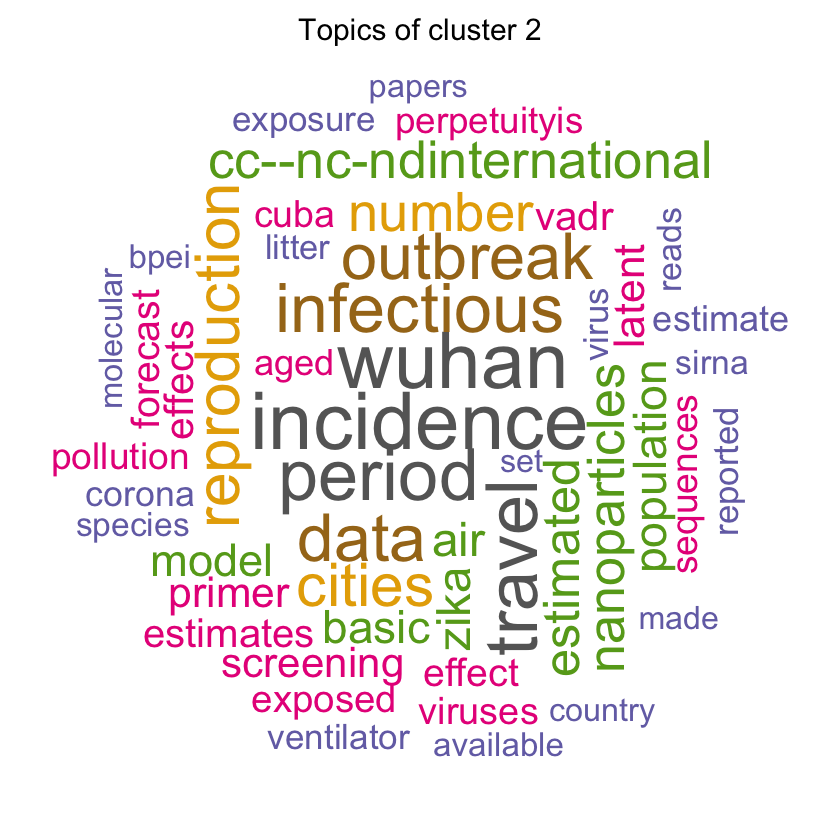

In [40]:
wordcloud(words = names(cluster_words[[2]]), freq = cluster_words[[2]], main = text(x=0.5, y=1, cex = 1.5, "Topics of cluster 2"), max.words = 50, random.order = F, rot.per=0.35, colors=brewer.pal(8, "Dark2"))

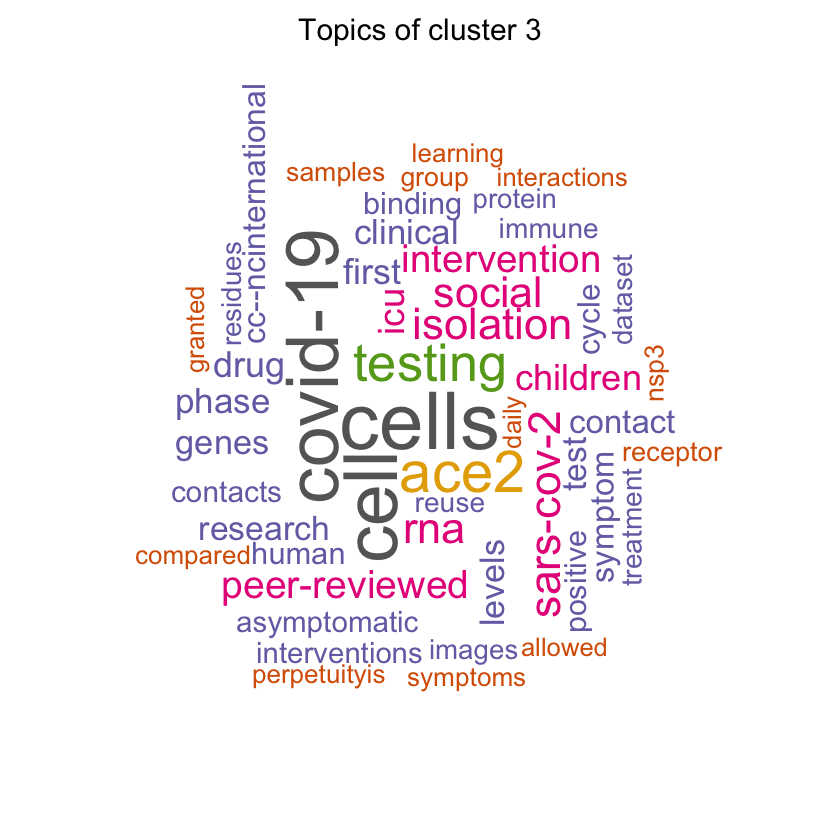

In [41]:
wordcloud(words = names(cluster_words[[3]]), freq = cluster_words[[3]], main = text(x=0.5, y=1, cex = 1.5, "Topics of cluster 3"), max.words = 50, random.order = F, rot.per=0.35, colors=brewer.pal(8, "Dark2"))

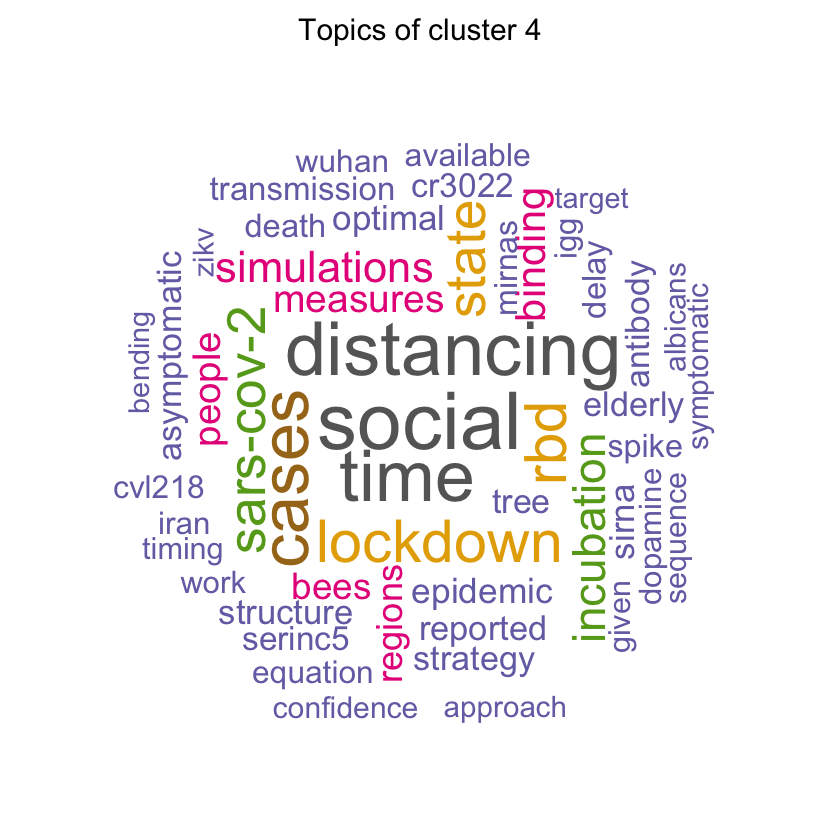

In [42]:
wordcloud(words = names(cluster_words[[4]]), freq = cluster_words[[4]], main = text(x=0.5, y=1, cex = 1.5, "Topics of cluster 4"), max.words = 50, random.order = F, rot.per=0.35, colors=brewer.pal(8, "Dark2"))

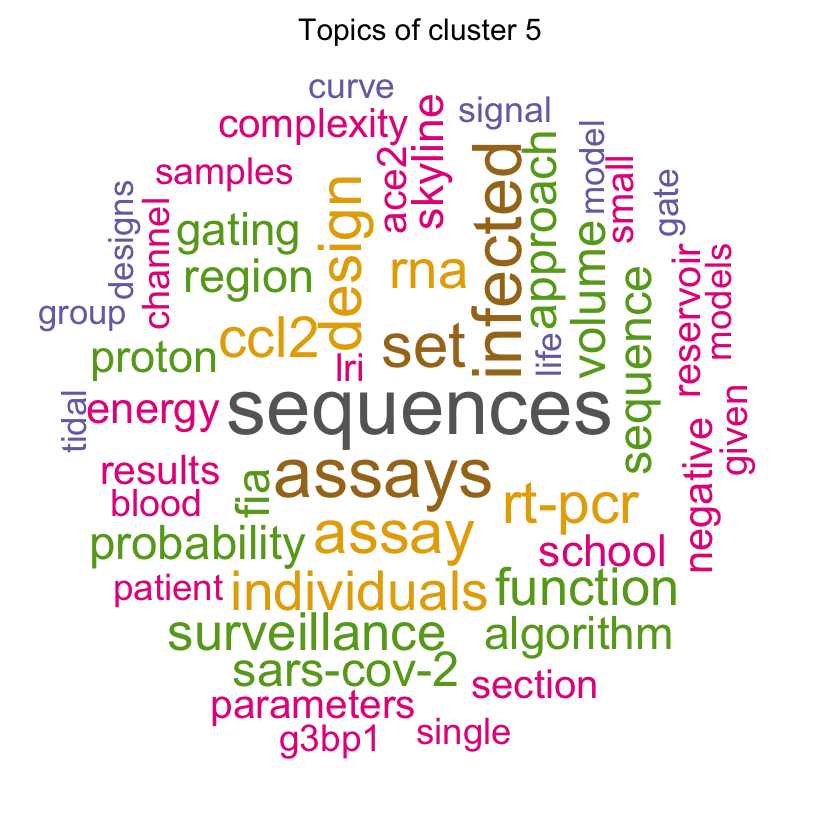

In [43]:
wordcloud(words = names(cluster_words[[5]]), freq = cluster_words[[5]], main = text(x=0.5, y=1, cex = 1.5, "Topics of cluster 5"), max.words = 50, random.order = F, rot.per=0.35, colors=brewer.pal(8, "Dark2"))

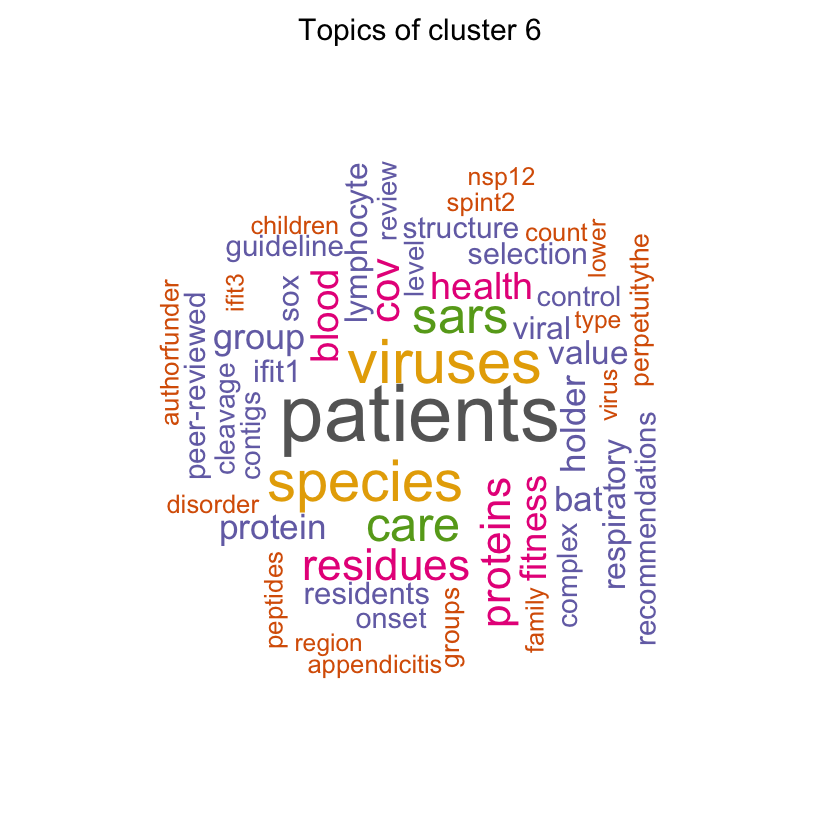

In [44]:
wordcloud(words = names(cluster_words[[6]]), freq = cluster_words[[6]], main = text(x=0.5, y=1, cex = 1.5, "Topics of cluster 6"), max.words = 50, random.order = F, rot.per=0.35, colors=brewer.pal(8, "Dark2"))

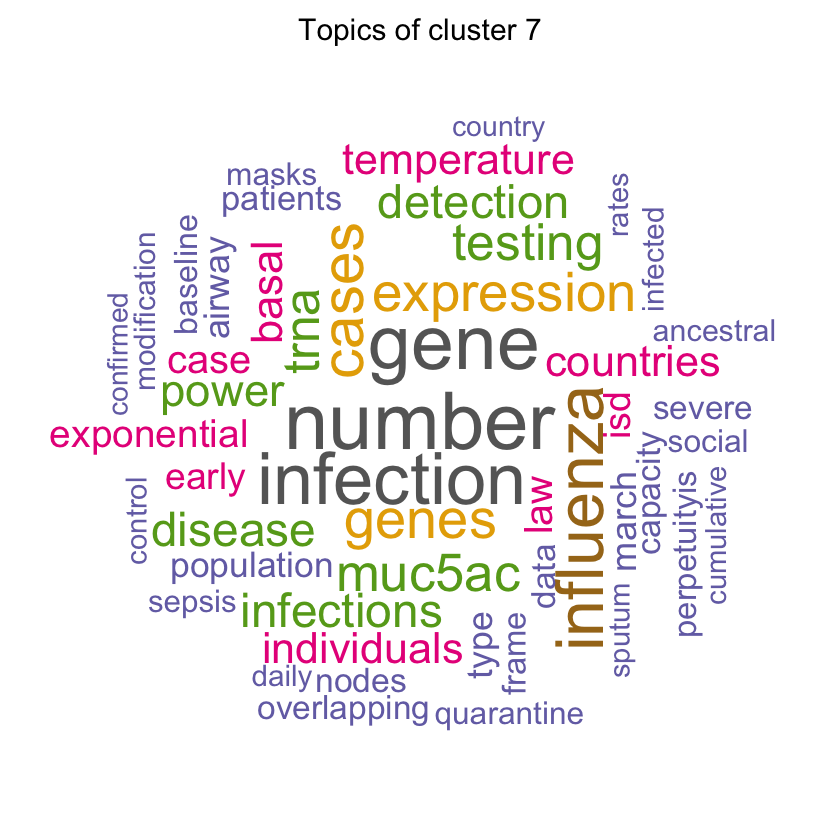

In [45]:
wordcloud(words = names(cluster_words[[7]]), freq = cluster_words[[7]], main = text(x=0.5, y=1, cex = 1.5, "Topics of cluster 7"), max.words = 50, random.order = F, rot.per=0.35, colors=brewer.pal(8, "Dark2"))

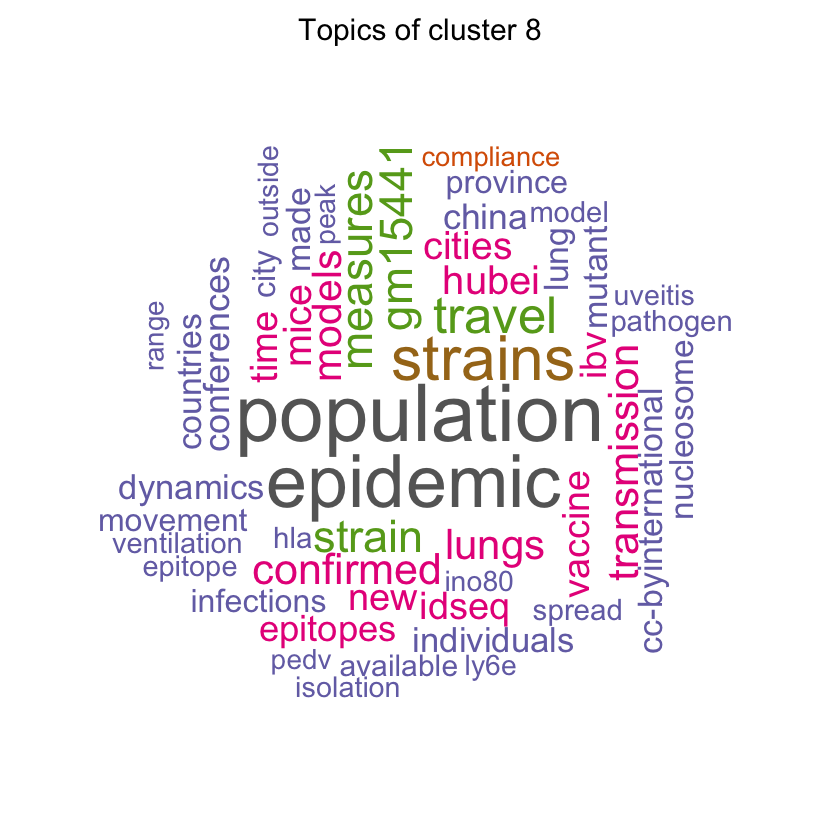

In [46]:
wordcloud(words = names(cluster_words[[8]]), freq = cluster_words[[8]], main = text(x=0.5, y=1, cex = 1.5, "Topics of cluster 8"), max.words = 50, random.order = F, rot.per=0.35, colors=brewer.pal(8, "Dark2"))

### Clustering visualization

In [ ]:
# Cluster Plot against 1st 2 principal components
# vary parameters for most readable graph 
clusplot(tdm.text, clustering, color=TRUE, shade=TRUE, 
   labels=2, lines=0)

# Centroid Plot against 1st 2 discriminant functions
plotcluster(mydata, clustering)

### Add lables to the papers according to the clustering topics

In [56]:
df.bm$label <- c(clustering)
df.bm$label[which(df.bm$label==1)] <- "bioinformatics"
df.bm$label[which(df.bm$label==2)] <- "analysis"
df.bm$label[which(df.bm$label==3)] <- "symptom"
df.bm$label[which(df.bm$label==4)] <- "social distance"
df.bm$label[which(df.bm$label==5)] <- "assay"
df.bm$label[which(df.bm$label==6)] <- "medical care"
df.bm$label[which(df.bm$label==7)] <- "genetics"
df.bm$label[which(df.bm$label==8)] <- "epidemic"

In [57]:
head(data.frame(df.bm$paper_id, df.bm$title, df.bm$label), 10)

df.bm.paper_id                          
1  0015023cc06b5362d332b3baf348d11567ca2fbb
2  00340eea543336d54adda18236424de6a5e91c9d
3  004f0f8bb66cf446678dc13cf2701feec4f36d76
4  005d189d5bd7ac01aee65e934fd3d5186a3f7b27
5  00911cf4f99a3d5ae5e5b787675646a743574496
6  009a88d2f0c810837ba60e5df7b5790eb71d2518
7  009ceadbb6f9f0d597b9516f0b9ca01e40231aad
8  00d16927588fb04d4be0e6b269fc02f0d3c2aa7b
9  00eb9220dc8cd351393b6b035323d350f103f8c6
10 0109d1273b2d59a099ab66cdad6939d5e7fcb2e8
   df.bm.title                                                                                                                                                                   
1  The RNA pseudoknots in foot-and-mouth disease virus are dispensable for genome replication but essential for the production of infectious virus. 2 3                          
2  Analysis Title: Regaining perspective on SARS-CoV-2 molecular tracing and its implications                                                                                    
3  Healthcare-resource-adjusted vulnerabilities towards the 2019-nCoV epidemic across China                                                                                      
4  Relationship between Average Daily Temperature and Average Cumulative Daily Rate of Confirmed Cases of COVID-19                                                               
5  CHEER: hierarCHical taxonomic classification for viral mEtagEnomic data via deep leaRning                                                                                     
6  A Novel Heuristic Global Algorithm to Predict the COVID-19 Pandemic Trend                                                                                                     
7  Impact of COVID-19 pandemic on severity of illness and resources required during intensive care in the greater New York City area                                             
8  Real-time, MinION-based, amplicon sequencing for lineage typing of infectious bronchitis virus from upper respiratory samples                                                 
9  Title: Impact of COVID-19 on psychiatric assessment in emergency and outpatient settings measured using electronic health records Running Title: COVID-19 and psychiatry notes
10 Neutrophil extracellular traps (NETs) as markers of disease severity in COVID-19                                                                                              
   df.bm.label   
1  bioinformatics
2  analysis      
3  analysis      
4  symptom       
5  analysis      
6  analysis      
7  analysis      
8  bioinformatics
9  analysis      
10 symptom

## 4.7 LDA Topic Modeling on the whole dataset

This code is dedicated to answer the question "What do we know about COVID-19 risk factors?",therefore we will analyze only abstracts plus titles which contain the word "risk".

In [ ]:
setwd("F:/")
metaData=read_csv(file="metadata.csv", col_names = TRUE)

In [6]:
#Extract Text columns from the metaData file
Corpus=metaData[, c("cord_uid","title", "abstract")]

#concatenate Text cloumns in a new cloumn (abstracts plus titles)
Corpus$text<-paste(Corpus$title, Corpus$abstract, sep=" ")

#Remove unneeded colums
Corpus$title <- NULL
Corpus$abstract <- NULL

In [7]:
CorpusQ3=dplyr::filter(Corpus, grepl("risk",text))

#The total number of these researches  
nrow(CorpusQ3)

[1] 5415

In [8]:
#Clean the Corpus (CorpusQ3)
CorpusQ3 <- dplyr::mutate(CorpusQ3, text  = gsub("[^[:alnum:] ]", " ", text)) # remove Alphanumeric characters
CorpusQ3 <- dplyr::mutate(CorpusQ3, text  = gsub("[[:punct:]]", " ", text))   # replace punctuation with space
CorpusQ3 <- dplyr::mutate(CorpusQ3, text  = gsub("[[:cntrl:]]", " ", text))   # replace control characters with space 
CorpusQ3 <- dplyr::mutate(CorpusQ3, text  = gsub("^[[:space:]]+", "", text))  # remove whitespace at beginning of text
CorpusQ3 <- dplyr::mutate(CorpusQ3, text  = gsub("[[:space:]]+$", "", text))  # remove whitespace at end of text
CorpusQ3 <- dplyr::mutate(CorpusQ3, text  = gsub("[0-9]", "", text))          # remove numbers
CorpusQ3 <- dplyr::mutate(CorpusQ3, text  = gsub("\\b\\w{1,2}\\b","", text))  # remove words with lengh one or two charachters
CorpusQ3$text=tolower(CorpusQ3$text)                                          # replace all Upper case characters to Lower case characters

Now we remove stop words.Also for the corpus of this question, Words like “review” are used very often in the abstracts, and they are not too meaningful.

The word cloud graph below shows that the most word frequncey used in the researches mentioned is "risk".

To have a closer look, the top 10 freqently used words are risk, patients, infection, disease, health, respiratory, virus, influenza, infections which may mean that the risk of this virus lies in infection through breathing (respiratory), such as influenza.

Joining, by = "word"

Joining, by = "word"

Warning message in brewer.pal(10, "Dark2"):
“n too large, allowed maximum for palette Dark2 is 8
Returning the palette you asked for with that many colors
”


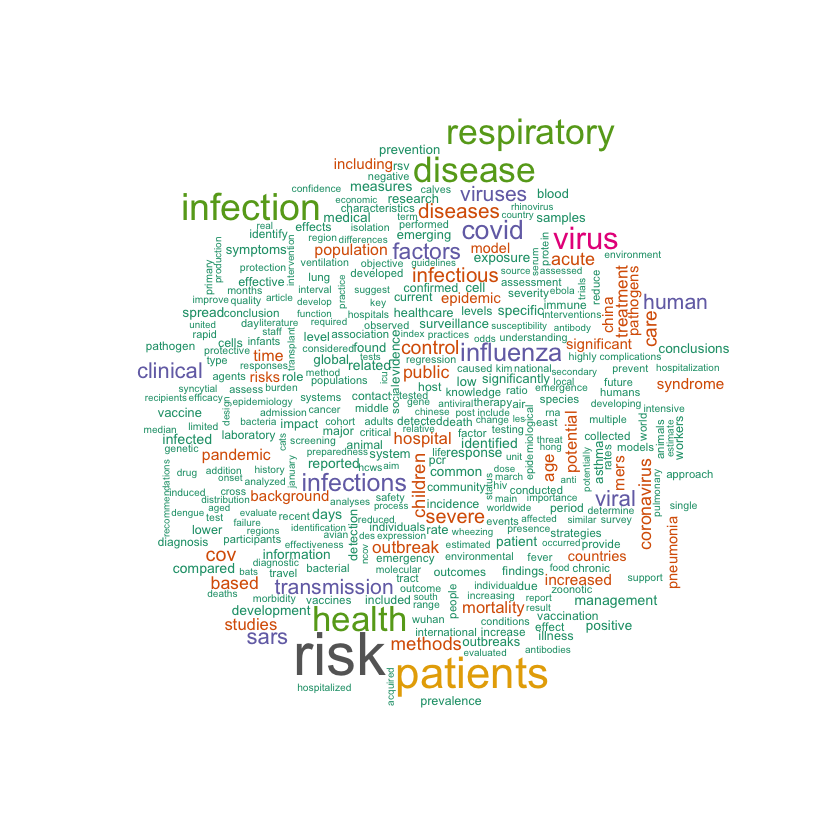

In [80]:
data(stop_words)
my_stopwords <- tibble(word = c(as.character(1:10),"review","systematic","results","total","users","authorized","data", "study", "abstract", "summary", "chapter", "meta","analysis","online","version"))

CorpusQ3.tm <- unnest_tokens(CorpusQ3, word, text) %>% 
anti_join(stop_words)%>%
anti_join(my_stopwords)%>%
count(word) %>%
with(wordcloud(word, n, max.words = 350, scale=c(3,.4),use.r.layout = FALSE, colors = brewer.pal(10,"Dark2")))

The graph below shows the pairs of words that occur together most often in description of the researches that mentioned the word "risk". 

Therefore, the popular pairs are "public & health", "risk & factor", "diseases & outbreak", "syndrome & respirator".

Also, the BiGram graph shows that there exist concerns on the risk on gobal healthcare workers, pregnant women, outbreak other viruses like Sars, Zika, other acute transmission disease, and concerns on the shortage of personal protective equipment.

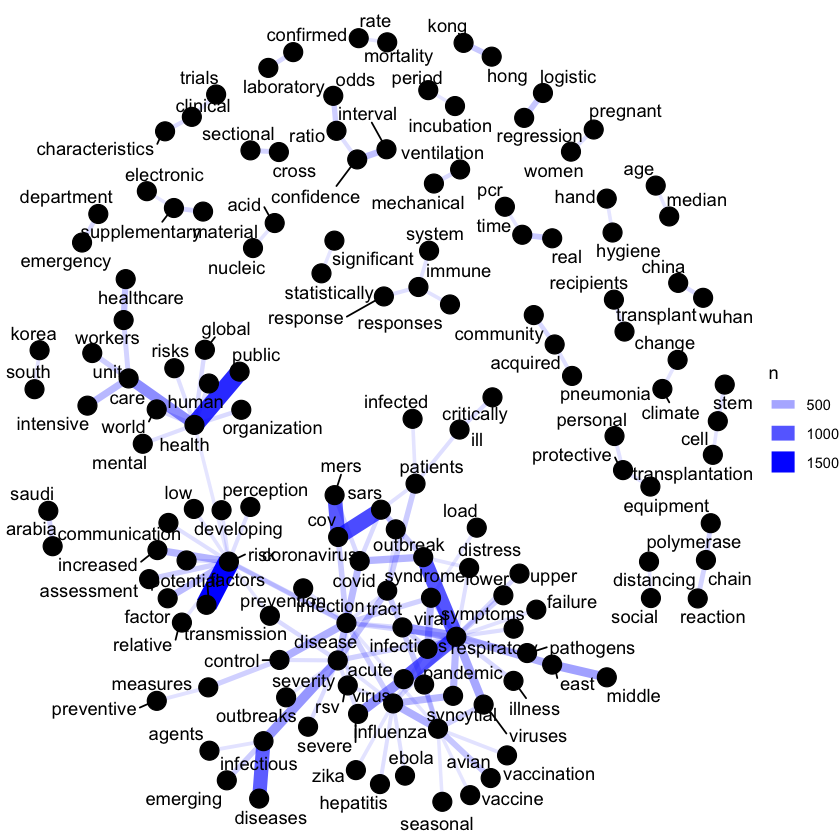

In [81]:
#get bigram

CorpusQ3_2_Gram= CorpusQ3 %>%
  unnest_tokens(bigram, text, token = "ngrams", n = 2)

CorpusQ3_2_Gram_Count=CorpusQ3_2_Gram %>%
  count(bigram, sort = TRUE)

bigrams_separated <- CorpusQ3_2_Gram %>%
  separate(bigram, c("word1", "word2"), sep = " ")

#remove stop words

bigrams_filteredA <- bigrams_separated %>%
  filter((!word1 %in% stop_words$word)) %>%
  filter((!word2 %in% stop_words$word))

bigrams_filtered <- bigrams_filteredA %>%
  filter((!word1 %in% my_stopwords$word)) %>%
  filter((!word2 %in% my_stopwords$word))

# new bigram counts:
bigram_counts <- bigrams_filtered %>% 
  count(word1, word2, sort = TRUE)

# draw the graph
set.seed(5561)
bigram_counts %>%
  filter(n >= 100) %>%
  graph_from_data_frame() %>%
  ggraph(layout = "fr") +
  geom_edge_link(aes(edge_alpha = n, edge_width = n), edge_colour = "blue") +
  geom_node_point(size = 5) +
  geom_node_text(aes(label = name), repel = TRUE, 
                 point.padding = unit(0.2, "lines")) +
  theme_void()

Next we use topic modeling cluster text data. 

The three Topic models show that the concerns on infection, pathogen and transmission, and the relationship between coronavirus and mers, influnenza, sars, and effects on patients through respiratory.

Joining, by = "word"Joining, by = "word"

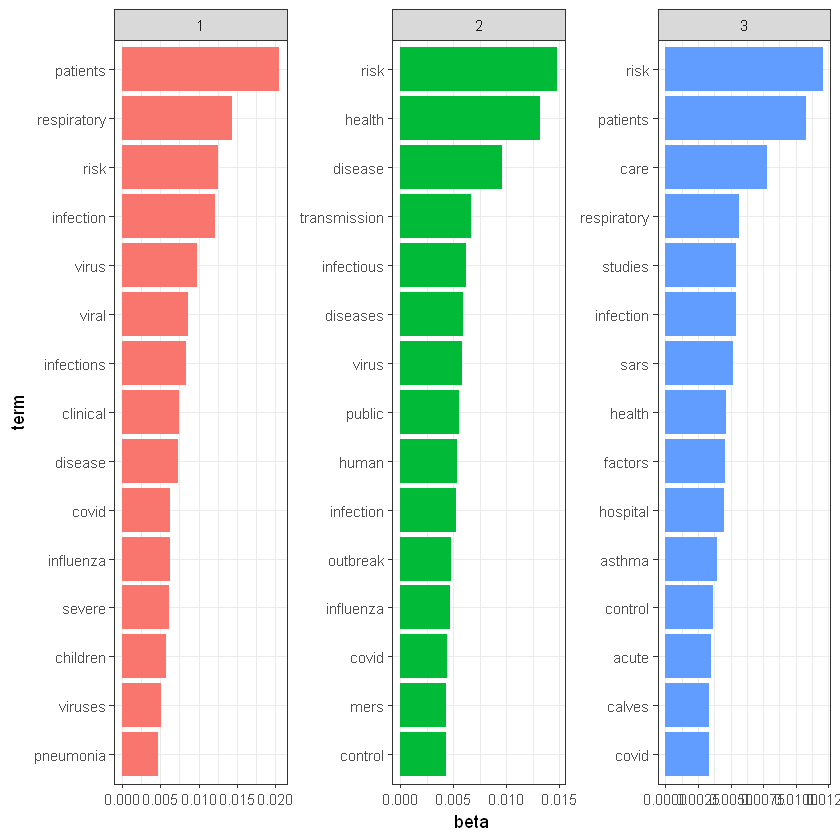

In [19]:
# unnest_tokens
CorpusQ3_tm <- unnest_tokens(CorpusQ3, word, text)%>%
anti_join(stop_words)%>%
anti_join(my_stopwords)

# get dtm matrix
CorpusQ3.dtm <- CorpusQ3_tm %>%
  count(cord_uid, word) %>%    ## word frequency
  cast_dtm(cord_uid, word, n)  ## convert to dtm matrix                

# Get three topics from the researches mentioned word "risk"
ap_lda <- LDA(CorpusQ3.dtm, k = 3, control = list(seed = 1234))
ap_topics <- tidy(ap_lda, matrix = "beta")


ap_top_terms <- ap_topics %>%
  group_by(topic) %>%
  top_n(15, beta) %>%
  ungroup() %>%
  arrange(topic, -beta)

#ap_top_terms

theme_set(theme_bw())

ap_top_terms %>%
  mutate(term = reorder_within(term, beta, topic)) %>%
  ggplot(aes(term, beta, fill = factor(topic))) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~ topic, scales = "free") +
  coord_flip() +
  scale_x_reordered()

# 5 Explortary data analysis on metadata

## 5.1 Generate dataframe for metadata

In [60]:
# function of converting metadata to structured data
format.metadata <- function(list, df){
  df.author <- data.frame(paper_id=character(), title=character(), author=character())
  for (i in 1:nrow(df)) {
    temp <- data.frame(paper_id = rep(df$paper_id[i], length(format.author(list, i))), 
                       title = rep(df$title[i], length(format.author(list, i))),
                       author = format.author(list, i))
    df.author <- rbind.fill(df.author, temp)
  }
  df.aff <- data.frame(paper_id=character(), author=character(), laboratory=character(), institution=character(), settlement=character(), region=character(), country=character())
  for (i in 1:length(list)) {
    if (is.null(nrow(list[[i]]$metadata$authors))==F){
      if (is.null(list[[i]]$metadata$authors$affiliation$laboratory)==T){
        laboratory <- rep(NA, nrow(list[[i]]$metadata$authors))
      } else{
        laboratory <- list[[i]]$metadata$authors$affiliation$laboratory
      }
      if (is.null(list[[i]]$metadata$authors$affiliation$institution)==T){
        institution <- rep(NA, nrow(list[[i]]$metadata$authors))
      } else{
        institution <- list[[i]]$metadata$authors$affiliation$institution
      }
      if (is.null(list[[i]]$metadata$authors$affiliation$location$settlement)==T){
        settlement <- rep(NA, nrow(list[[i]]$metadata$authors))
      } else{
        settlement <- list[[i]]$metadata$authors$affiliation$location$settlement
      }
      if (is.null(list[[i]]$metadata$authors$affiliation$location$region)==T){
        region <- rep(NA, nrow(list[[i]]$metadata$authors))
      } else{
        region <- list[[i]]$metadata$authors$affiliation$location$region
      }
      if (is.null(list[[i]]$metadata$authors$affiliation$location$country)==T){
        country <- rep(NA, nrow(list[[i]]$metadata$authors))
      } else{
        country <- list[[i]]$metadata$authors$affiliation$location$country
      }
      temp <- data.frame(paper_id=rep(df$paper_id[i], length(format.author(list, i))), 
                         author = format.author(list, i), 
                         laboratory, institution, settlement, region, country)
    } else{
      temp <- data.frame(paper_id=NA, author=NA, laboratory=NA, institution=NA, settlement=NA, region=NA, country=NA)
    }
    df.aff <- rbind.fill(df.aff, temp)
  }
  df.metadata <- merge(x = df.author, y = df.aff, by = c("paper_id", "author"))
  return(df.metadata)
}

df.metadata.bm <- format.metadata(raw.list.bm, df.bm)
df.metadata.comm <- format.metadata(raw.list.comm, df.comm)
df.metadata.noncomm <- format.metadata(raw.list.noncomm, df.noncomm)

In [62]:
df.metadata.bm[15:20,]

paper_id                                 author          
15 0015023cc06b5362d332b3baf348d11567ca2fbb Stonehouse A    
16 0015023cc06b5362d332b3baf348d11567ca2fbb Tobias J Tuthill
17 0015023cc06b5362d332b3baf348d11567ca2fbb Warner          
18 00340eea543336d54adda18236424de6a5e91c9d Carla Mavian    
19 00340eea543336d54adda18236424de6a5e91c9d Costanza Manes  
20 00340eea543336d54adda18236424de6a5e91c9d Ilaria Capua    
   title                                                                                                                                               
15 The RNA pseudoknots in foot-and-mouth disease virus are dispensable for genome replication but essential for the production of infectious virus. 2 3
16 The RNA pseudoknots in foot-and-mouth disease virus are dispensable for genome replication but essential for the production of infectious virus. 2 3
17 The RNA pseudoknots in foot-and-mouth disease virus are dispensable for genome replication but essential for the production of infectious virus. 2 3
18 Analysis Title: Regaining perspective on SARS-CoV-2 molecular tracing and its implications                                                          
19 Analysis Title: Regaining perspective on SARS-CoV-2 molecular tracing and its implications                                                          
20 Analysis Title: Regaining perspective on SARS-CoV-2 molecular tracing and its implications                                                          
   laboratory institution           settlement  region country
15 NA         NA                    NA          NA     NA     
16 NA         NA                    NA          NA     NA     
17 NA         NA                    NA          NA     NA     
18            University of Florida Gainesville FL     USA    
19            University of Florida Gainesville FL     USA    
20            University of Florida Gainesville FL     USA

# 6 Future Work

Text mining on other subsets, classification with neural networks.